Copyright (c) 2023 Graphcore Ltd. All rights reserved.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Check we can see our IPUs!
# Top line should say Partition: {partition_name} has {n} reconfigurable IPUs if successful
!gc-monitor

+---------------+---------------------------------------------------------------------------------+
|  gc-monitor   |          Partition: 201627-reconfig [active] has 4 reconfigurable IPUs          |
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+
|    IPU-M    |       Serial       |IPU-M SW|Server version|  ICU FW  | Type  | ID | IPU# |Routing|
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+
|  10.5.13.3  | 0131.0002.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 0  |  3   |  DNC  |
|  10.5.13.3  | 0131.0002.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 1  |  2   |  DNC  |
|  10.5.13.3  | 0131.0001.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 2  |  1   |  DNC  |
|  10.5.13.3  | 0131.0001.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 3  |  0   |  DNC  |
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+


## Optimizing memory usage with custom ops: a case study with Flash Attention

If you have ever tried porting an arbitary pytorch model to the IPU, your first attempt to run the model will likely have resulted in an out-of-memory (OOM) error. Most pytorch models have been written to fit all weights, cached activations, and optimizer state on a single GPU with ≥16GB VRAM, whereas a single IPU has around 900 MB SRAM. How on earth [[1](https://www.theregister.com/2022/06/16/graphcore_nvidia_gpus/)] can an IPU [[2](https://www.hpcwire.com/2022/06/29/the-mainstreaming-of-mlperf-nvidia-dominates-training-v2-0-but-challengers-are-rising/)] with so little memory [[3](https://www.eetimes.com/graphcore-supercharges-ipu-with-wafer-on-wafer/)] be competitive with a GPU [[4](https://www.graphcore.ai/performance-results)]? 

The simple answer is that the performance of a majority of deep learning applications are limited by the rate at which they can read and write to the highest level of memory (memory-bandwidth bound) and the VRAM used in GPUs has much lower memory-bandwith (1-4 TB/s depending on GPU device) than the SRAM used in IPUs (65 TB/s). **This means that if you can squeeze your model into IPU memory it should run much faster than on GPU** (subject to any other overheads such as collective bandwidth, host-offloading etc.). Thankfully, Graphcore's software engineers have written some IPU-specific extensions to pytorch along with a [handy guide](https://docs.graphcore.ai/projects/memory-performance-optimisation/en/latest/common-memory-optimisations.html) on how to apply common memory optimisations to leverage these performance benefits.

If you read through the linked [handy guide](https://docs.graphcore.ai/projects/memory-performance-optimisation/en/latest/common-memory-optimisations.html) and scroll down to the bottom, you will notice a section with less detail than the others (*5.7 Writing a custom operation*), but clicking through you should eventually land on [a guide to writing custom ops for pytorch](https://docs.graphcore.ai/projects/popart-user-guide/en/latest/custom_ops.html). Here you should see an example of implementing a custom leaky relu op.

But what about a more meaty custom operation that actually does some kind memory optimisation? Enter FlashAttention [[5](https://arxiv.org/abs/2205.14135)][[6](https://arxiv.org/abs/2307.08691)], an optimised attention operator for GPUs that has recently been adopted by pytorch and others as the default attention implementation for large language models due to its ability to scale to large sequence lengths. The problem it solves is that a naive attention operation computes an intermediate "attention matrix" that you must read and write to memory. However, the size of this attention matrix scales squarely with the sequence length and makes reading and writing it very costly. For sequences over about 2048 tokens, communicating the attention matrix can become the main bottleneck in the runtime of a transformer model.

Their solution is to break up the attention computation into chunks such that the attention matrix never needs to be present in memory all at once. When these chunks are small enough, each chunk can fit into GPU L2 Cache (40-50 MB), eliminating the need to read from and write to VRAM. As a result FlashAttention adeptly overcomes a key bottleneck in training and high throughput inference of transformers.
 
The same algorithm can also be used to minimise the memory usage of the attention operation to allow us to run models with larger sequence lengths on the IPU.

In this notebook we will show a toy demonstration of what this looks like. We will 
1) Load a pytorch model workload we did not write ourselves (in this case [nanoGPT training](https://github.com/karpathy/nanoGPT/)) and show you what happens when run out of the box.
2) Profile the model to demonstrate that the attention matrix is eating up a lot of IPU memory
3) Show how our implementation of flash attention https://github.com/graphcore-research/flash-attention-ipu eliminates the contribution of the attention matrix to IPU memory usage
4) Successfully train nanoGPT!

### 1. Load nanoGPT and try to run

nanoGPT (a.k.a. the MNIST of 2023) is the de-facto mini-workload for testing and debugging new features of a deep learning toolkit. We take a small character-level variant of the model (about 10M parameters) and train it on the works of Shakespeare. Crucially, because backpropagation requires every operation to cache its output activations, these activations become the key memory bottleneck. The typical solution to this is to cache only a subset of these activation (activation checkpointing), and recompute the rest while the gradient graph is being traversed during backpropagation. 

We will not do that here so that we can provide a simple illustration of how you would go about optimising memory usage through a custom operation.

We'll now see what happens when we take nanoGPT and try to train it without doing any memory optimisations:

In [4]:
from nanoGPT import model
from train import config, train

In [5]:
gpt = model.GPT(config)

number of parameters: 10.67M


In [6]:
# Simple (non-optimised) trainer for IPU
train(gpt, experiment_name="standard-attn-train")

Training standard-attn-train ...
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped


/nethome/lukep/Projects/flash-attention-ipu-nanogpt-demo/train.py:179: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1462.)
  split: torch.frombuffer(
/nethome/lukep/envs/venv_poptorch_3.3.0/lib/python3.8/site-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[13:45:52.555] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 78
[13:45:52.556] [poptorch:cpp] [warning] [DISPATCHER] Type coerced 

flash is not wrapped


Graph compilation: 100%|██████████| 100/100 [01:02<00:00]
[13:47:08.171] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 634
[13:47:08.173] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 635
[13:47:08.173] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 636


flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped


Graph compilation: 100%|██████████| 100/100 [02:10<00:00]
2023-09-08T13:49:20.449456Z popart:devicex 93586.93586 E: Memory allocation error : /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3536 Out of memory on tile 0: 876060 bytes used but tiles only have 638976 bytes of memory
2023-09-08T13:49:20.450827Z popart:popart 93586.93586 E: /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3536 Out of memory on tile 0: 876060 bytes used but tiles only have 638976 bytes of memory

[0] popart::popx::Devicex::prepare()
[1] popart::Session::prepareDevice(bool)
[2] poptorch::popart_compiler::Compiler::compileAndPrepareDevice()
[3] poptorch::detail::LowerToPopartImpl::compile()
[4] poptorch::LowerToPopart::compile()



[13:49:20.451] [poptorch:cpp] [error] Out of memory, the graph profile is available here: 


Error: In unknown:0: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3536 Out of memory on tile 0: 876060 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithManualTracing


### OOM error! 😭 

Oh dear. As promised, we've exceeded 900 MB of IPU memory.

#### What now?

### 2. Profile the model to find out what is eating up all of our memory

Thankfully, the benevolent and hardworking army of Graphcore software engineers built a useful tool called [Popvision Analyser (`pva`)](https://www.graphcore.ai/developer/popvision-tools) for obtaining detailed profiles of how models are compiled to run on IPU. Bundled in with the poplar SDK is a [python API](https://docs.graphcore.ai/projects/libpva/en/latest/intro.html) for scraping information from these profiles. We use this API to build a couple of utilities for displaying this information in a notebook.

This time we'll run the same experiment again, but with profiling turned on. It will still go out of memory, but at least the IPU will give us something back to find out why.

Look in the stack trace for where it says our model is profiled: `Out of memory, the graph profile is available here: profiles/standard-attn-profile/training/profile.pop`

In [7]:
gpt.destroy()
gpt = model.GPT(config)

number of parameters: 10.67M


In [8]:
train(gpt, experiment_name="standard-attn-profile", profile=True)

Training standard-attn-profile ...
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped


[13:51:18.899] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1190
[13:51:18.900] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1191
[13:51:18.900] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1192
Graph compilation: 100%|██████████| 100/100 [01:13<00:00]
[13:52:52.264] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1746
[13:52:52.265] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1747
[13:52:52.265] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1748


flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped


Graph compilation:   0%|          | 0/100 [00:00<?]
2023-09-08T13:55:53.008161Z popart:devicex 93586.93586 E: Memory allocation error : /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3536 Out of memory: Cannot fit all variable data onto one or more tiles. Profile saved to: profiles/standard-attn-profile/training/profile.pop
2023-09-08T13:55:53.009326Z popart:popart 93586.93586 E: /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3536 Out of memory: Cannot fit all variable data onto one or more tiles. Profile saved to: profiles/standard-attn-profile/training/profile.pop

[0] popart::popx::Devicex::prepare()
[1] popart::Session::prepareDevice(bool)
[2] poptorch::popart_compiler::Compiler::compileAndPrepareDevice()
[3] poptorch::detail::LowerToPopartImpl::compile()
[4] poptorch::LowerToPopart::compile()



[13:55:53.009] [poptorch:cpp] [error] Out of memory, the graph profile is 

Error: In unknown:0: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3536 Out of memory: Cannot fit all variable data onto one or more tiles. Profile saved to: profiles/standard-attn-profile/training/profile.pop
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithManualTracing
  [4] popart::popx::Devicex::prepare()
  [5] popart::Session::prepareDevice(bool)
  [6] poptorch::popart_compiler::Compiler::compileAndPrepareDevice()
  [7] poptorch::detail::LowerToPopartImpl::compile()
  [8] poptorch::LowerToPopart::compile()


### Inspecting a liveness trace

We're going to plot what we call a "liveness trace". When we compile a model, the compiler figures out a sequence of "program steps" to execute one after the other. The liveness trace shows us how much memory is being used during each program step. For a training step, you will typically see a ramp up during the forward pass while tensors are generated and cached for the backward pass, a peak when the loss is computed, and a ramp down during the backward pass while activations are consumed and deleted once they are no longer needed.

You can split up the variables stored in memory by those that are needed throughout the program (always live/ constant memory variables, e.g., weights, accumulation buffers, code) and those that are created and destroyed somewhere in the middle of the program (not always live/ temporary memory variables, e.g., gradients, activations).

In [9]:
from profile_utils import plot_liveness_trace, get_step_variables

In [10]:
standard_attn_report = "./profiles/standard-attn-profile/training/profile.pop"

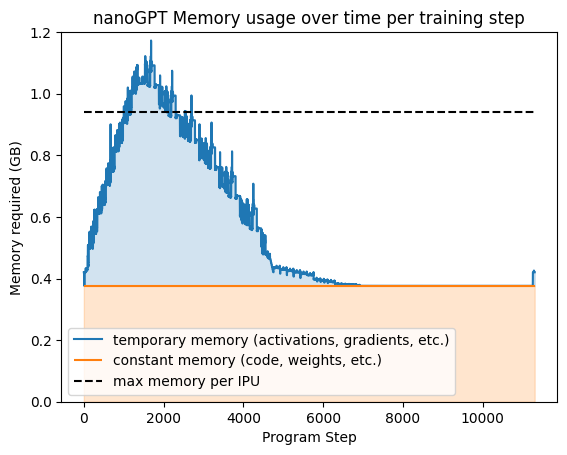

In [11]:
plot_liveness_trace(standard_attn_report)

The liveness trace shows use that our memory usage exceeds the maximum available memory close at around step 1500, with peak memory usage at around step 1800.

Let's inspect the size of the variables at step 1800 to see which variables are eating up most of the available memory.

In [12]:
df = get_step_variables(standard_attn_report, step_num=1800)

In [13]:
df.head(12)

,MB
3749/4/attn/Softmax:0,50.331648
5/attn/Softmax/3674/SoftmaxGrad/SoftMaxGradient/Op/Multiply/Out,50.331648
0/attn/Softmax/4190/0/attn/Softmax:0,50.331648
0/attn/Softmax/4190/call_subgraph(17)/1/attn/Softmax:0,50.331648
3726/1/attn/Softmax:0,50.331648
3749/2/attn/Softmax:0,50.331648
0/mlp/c_fc/Reshape/4371/0/mlp/c_fc/Reshape:0/1,12.582912
2/mlp/gelu/Gelu/295,12.582912
0/mlp/gelu/Gelu/161,12.582912
1/mlp/gelu/Gelu/3729,12.582912


***A bit of background*** *: our pytorch compiler assigns names to each activation tensor based on the operation that generated it.*

Here we can see the top contributors to memory usage. The top 6 are all called something like `foo/Softmax:0`, meaning they are the output of a softmax operation. Which tensor is the output of a softmax operation? The attention matrix!

We can therefore see that the cached attention matrices over all layers eats up about a third of the IPU's memory!

So let's get rid of them.

In [14]:
gpt.destroy()
gpt = model.GPT(config)

number of parameters: 10.67M


### 3. Solving OOM with `import flash_attention_ipu.auto`

Here we'll import a small library of custom ops implementing flash attention on the ipu. There are currently a number of ways that public pytorch models use flash attention, including via the [flash attention library](https://github.com/Dao-AILab/flash-attention), [custom triton implementations](https://github.com/mosaicml/llm-foundry/blob/main/llmfoundry/models/layers/flash_attn_triton.py), or using `torch.nn.functional.scaled_dot_product_attention` directly in pytorch (as of pytorch 2.0 release).

nanoGPT uses the latter implementation (see https://github.com/karpathy/nanoGPT/blob/master/model.py#L64). This function makes a choice for the user amongst various fused-attention schemes based on tensor shapes, hardware (CPU or GPU), and other arguments (e.g., masks). Since the pytorch compiler first traces the model on CPU, this results in a non-optimal function being traced for IPU. 

As such we present `flash_attention_ipu`, which provides a more efficient lowering of `torch.nn.functional.scaled_dot_product_attention` for the IPU. Importing `flash_attention_ipu.auto` automatically patches `torch.nn.functional.scaled_dot_product_attention` and the job is done!

In [15]:
import flash_attention_ipu.auto

Let's profile the model again to check that we have successfully overcome our OOM issue.

In [16]:
train(gpt, experiment_name="flash-attn-profile", profile=True)

Training flash-attn-profile ...
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped


/nethome/lukep/envs/venv_poptorch_3.3.0/lib/python3.8/site-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[14:04:24.177] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2302
[14:04:24.177] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2303
[14:04:24.177] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2304
Graph compilation: 100%|██████████| 100/100 [00:43<00:00]
[14:05:38.244] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2738
[14:05:38.245] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2739
[14:05:38.245] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2740


flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped


100%|██████████| 1/1 [00:00<00:00, 13273.11it/s]


### Success! 🎉

How does the liveness trace look now?

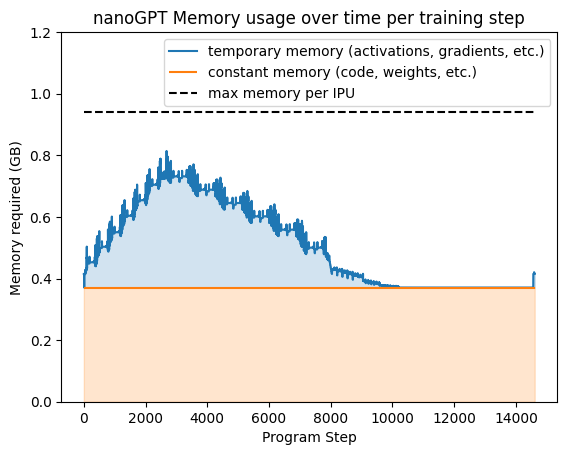

In [17]:
flash_attn_report = "./profiles/flash-attn-profile/training/profile.pop"
plot_liveness_trace(flash_attn_report)

We have a healthy clearance with our memory limit.

If we wanted to take this further, what should we target next? What are the next biggest contributors to our memory consumption that might become a problem with larger models?

The peak memory usage is around program step 2500 now, so let's look there.

In [18]:
df = get_step_variables(flash_attn_report, step_num=2500)
df.head(16)

,MB
0/mlp/gelu/Gelu/3132/3/mlp/gelu/Gelu:0,12.582912
0/mlp/gelu/Gelu/3132/2/mlp/gelu/Gelu:0,12.582912
0/mlp/c_fc/Reshape/3530/3/mlp/c_fc/Reshape:0/1,12.582912
0/mlp/c_fc/Reshape/3530/2/mlp/c_fc/Reshape:0/1,12.582912
0/mlp/c_fc/Reshape/3530/1/mlp/c_fc/Reshape:0/1,12.582912
0/mlp/c_fc/Reshape/3530/0/mlp/c_fc/Reshape:0/1,12.582912
0/mlp/c_fc/Gemm/3127/matmulGrouped/Conv_1/serialOut[0],12.582912
0/mlp/gelu/Gelu/3132,12.582912
0/mlp/gelu/Gelu/3132/0/mlp/gelu/Gelu:0,12.582912
0/mlp/gelu/Gelu/3132/1/mlp/gelu/Gelu:0,12.582912


*Remember: tensors are named based on the operator that created them*

Here we can see 6 tensors with names of form `foo/Reshape` and 6 tensors with names of form `bar/Gelu`. What could these be?

Since we aren't doing any activation checkpointing, we know all intermediate tensors are being cached for the backwards pass. We know that there is a `gelu` in the middle of the transformer layer MLP, so the `bar/Gelu` tensors must be the hidden state of the MLP. The fact that these come out to 12.5 MB makes sense because we know the attention matrix came out to 50 MB, which should be 4x larger for a transformer with embedding dimension = 384, attention heads = 6, and sequence length = 1024.

The `foo/Reshape` are the same size as the `bar/Gelu` tensors, so we can guess that these are either the result of some reshaping after the MLP input matmul, or before the MLP output matmul. The name of the tensor is not descriptive enough to tell us which one it is exactly, but we have a rough idea where it might be fruitful to write some custom memory optimisations next!

### Let's complete a successful training run now

number of parameters: 10.67M
Training flash-attn-train ...


/nethome/lukep/envs/venv_poptorch_3.3.0/lib/python3.8/site-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[14:10:14.970] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 3174
[14:10:14.971] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 3175
[14:10:14.971] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 3176


flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped


Graph compilation: 100%|██████████| 100/100 [00:44<00:00]
[14:11:28.513] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 3610
[14:11:28.514] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 3611
[14:11:28.515] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 3612


flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped


100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s]  


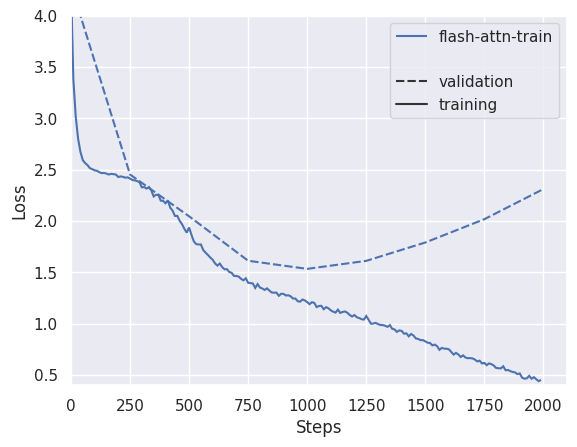

In [19]:
gpt = model.GPT(config)
train(gpt, experiment_name="flash-attn-train")

#### 🥳 📉 Huzzah! 📉 🥳

We can see the classic training and validation curves for a model overfitting the data.

### Wrapping up

In this notebook, we used a custom op from `flash_attention_ipu` to solve an OOM error with a public model we have tried to get running on IPU. We saw:

1. How an IPU responds when a model requires too much memory
2. How we can profile and inspect the state of a compiled model on IPU to diagnose how best to optimise memory usage
3. How the use of `flash_attention_ipu` eliminated major contributors to memory consumption
4. A successful training run of a model after fitting it in memory.

### Next steps

This notebook demonstrated a toy example of how to use custom ops to solve OOM errors when porting public models to IPU. We would first recommend trying to perform simpler memory optimisations outlined [here](https://docs.graphcore.ai/projects/memory-performance-optimisation/en/latest/common-memory-optimisations.html) first before writing a custom op. Can you figure out how to edit `train.py` to optimise nanoGPT for IPU and improve training time? Try looking at our poptorch [tutorials](https://github.com/graphcore/examples/tree/master/tutorials/tutorials/pytorch) and [BERT example](https://github.com/graphcore/examples/tree/master/nlp/bert/pytorch) to get a sense of how you can more rigourously optimise an application for the IPU.

Perhaps instead you want to get more experience writing custom ops? Or even to help improve our FlashAttention implementation? Take a look at our [poplar tutorials](https://github.com/graphcore/examples/tree/master/tutorials/tutorials/poplar) to see how to write lower level code for the IPU, and perhaps take a look at some of the other more meaty custom ops that have been implemented, such as for [ray tracing](https://github.com/graphcore-research/ipu-ray-lib), [distance matrices](https://github.com/graphcore-research/poptorch-experimental-addons/blob/main/poptorch_experimental_addons/cpp/distance_matrix.cpp), and [Non-Maximum Suppression](https://github.com/graphcore/NMS) for image segmentation. Also, you can try our experimental python library [`tesselate`](https://github.com/graphcore-research/tessellate-ipu) for writing low level IPU code, where you can explore the MIMD capabilities of the IPU for accelerating linear algebra!

If you want to stick with this notebook a little longer, we also have a few appendix items that might be of interest to you:

### Appendix A: Proof of numerical parity with and without `flash_attention_ipu`

If you are the skeptical type you might be thinking "Hang on! How do I even know you're computing attention correctly at all here? You haven't shown me any comparisons with a trusted baseline!".

1. This is a fantastic attitude to have and will serve you well in life!

2. Fear not! we'll show you a comparison with a training run using a shorter sequence length that doesn't need flash attention to fit on IPU.

number of parameters: 10.67M
Training standard-attn-train-blocksize256 ...
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped


/nethome/lukep/envs/venv_poptorch_3.3.0/lib/python3.8/site-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[14:24:59.905] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 4046
[14:24:59.905] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 4047
[14:24:59.906] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 4048
Graph compilation: 100%|██████████| 100/100 [00:26<00:00]
[14:25:38.327] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 4602
[14:25:38.328] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 4603
[14:25:38.329] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 4604


flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped
flash is not wrapped


100%|██████████| 2000/2000 [04:29<00:00,  7.42it/s] 


number of parameters: 10.67M
Training flash-attn-train-blocksize_256 ...
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped


/nethome/lukep/envs/venv_poptorch_3.3.0/lib/python3.8/site-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[14:31:51.453] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 5158
[14:31:51.453] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 5159
[14:31:51.454] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 5160
Graph compilation: 100%|██████████| 100/100 [00:31<00:00]
[14:32:38.280] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 5594
[14:32:38.281] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 5595
[14:32:38.282] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 5596


flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped
flash is wrapped


100%|██████████| 2000/2000 [05:01<00:00,  6.63it/s]  


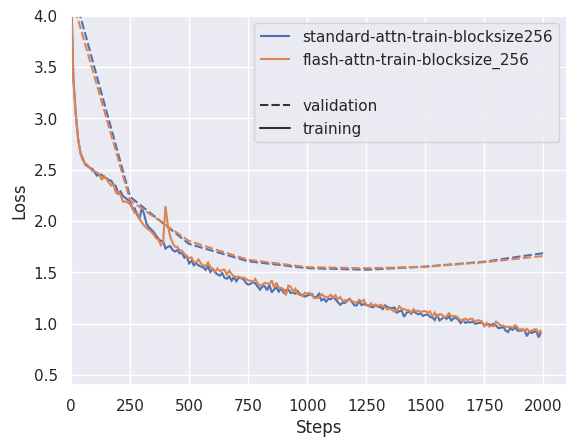

In [20]:
# Temporarily undo function patching
import torch.nn.functional as F
patched_fn = F.scaled_dot_product_attention
F.scaled_dot_product_attention = F.scaled_dot_product_attention.__wrapped__

gpt = model.GPT(config)
train(gpt, experiment_name="standard-attn-train-blocksize256", block_size=256)

# Reset patched function
F.scaled_dot_product_attention = patched_fn

gpt = model.GPT(config)
train(gpt, experiment_name="flash-attn-train-blocksize_256", block_size=256)

These training and validation curves are pretty much the same, subject to a bit of randomness and non-associativity of floating point arithmetic.

If you need more convincing, take a look at the [tests](https://github.com/graphcore-research/flash-attention-ipu/blob/main/tests/python/test_flash_attention_qkv_packed.py). 

### Appendix B: A context of 1024 is still quite small. Surely with 900 MB of SRAM you can go bigger?

**This appendix section is not as performant as I was expecting it to be (should be able to get 8x larger tensors in)**

It is possible to fit much larger context lengths, but it is application dependent. Even with plenty of memory optimisations, training workloads have quite a large memory footprint that scales with micro-batch size and number of model layers as you need to save some activation checkpoints. Inference workloads usually have much smaller memory footprint as activations generally don't need to be cached (U-net is an exception), but sometimes they are to reduce latency (for example in autoregressive token generation). 

A good application of `flash_attention_ipu` with long context length is the prefill phase of large language model inference wits lots of additional context retrieved from a database, or generating embeddings for very long documents.

For now we'll just show a simple mini-benchmark for a representative workload that would be part of a larger production system.

A typical IPU setup for a large language model would split weights across multiple chips, potentially storing weights in external memory buffers if the available SRAM in the system is less than is required for the whole model. For attention, this would mean splitting heads across multiple chips as these are easily parallelised and require no communication between chips. 

- For the sake of argument, let's say we have 8 attention heads per chip. 

- Since IPUs can still attain high throughput at low batch sizes, we might set our batch size to 4.

- Attention heads usually have a head dimension of 128, so let's use that for our representative benchmark.

- We'll assume float16 datatype for activation tensors since we can half our memory usage and double our FLOPs.

We have 900 MB of SRAM, but we often need to reserve about 250 MB for code, leaving 650 MB left for the operation.

The attention operation itself takes in 3 tensors and outputs 1 tensor, each of size `[batch_size, num_heads, ctx_len, head_dim]`. For float16 (2 bytes per element) with `batch_size=1`, `num_heads=8`, `head_dim=128`, the function will need at least `2 * 4 * 128 * ctx_len` bytes = `1024 * ctx_len` bytes. If we chunked up the attention operation to be super small so that it had next to overhead, we should be able to fit a context length of `650 * 10**6 / 1024 = 158691`. 

Realistically, we want the attention operation to have large enough chunks that we get decent FLOP utilisation, so we need to account for both a mask chunk and attention chunk. To make the maths easy, lets say these chunks are the same size as the individual input and output tensors. That means the function would need at least `(1024 + 512) * ctx_len` bytes = `6144 * ctx_len` bytes. Realistically then, we should be able to fit a context length of 105764.

Finally, we'll also round down to the nearest power of 2 (`ctx_len = 2**16 = 65536`) to allow ourselves a little more room for memory overheads.

In [9]:
import torch
import poptorch

# We'll use the flash_attention op directly so we can control chunk size
from flash_attention_ipu import flash_attention_qkv_packed

batch_size = 1
num_heads = 8
ctx_len = 65536
head_dim = 64

qkv = torch.randn(3, batch_size, num_heads, ctx_len, head_dim, dtype=torch.float16)

class AttentionBenchmarker(torch.nn.Module):
    def __init__(self, qkv):
        super().__init__()
        self.register_buffer("qkv", qkv)
    
    def forward(self):
        return flash_attention_qkv_packed(self.qkv.reshape(3, -1, *self.qkv.shape[-2:]), num_chunks_q=64, num_chunks_kv=64)

benchmarker = poptorch.inferenceModel(AttentionBenchmarker(qkv))

out = benchmarker()

print(f"Attention operation with size [{batch_size}, {num_heads}, {ctx_len}, {head_dim}] ran successfully")

Graph compilation: 100%|██████████| 100/100 [00:27<00:00]


Attention operation with size [1, 8, 65536, 64] ran successfully


### Appendix C: Dive into poplar implementation of FlashAttention

If you've made it this far and felt like you haven't seen enough code, you're in luck! Here we'll take you through the poplar implementation of FlashAttention (see https://github.com/graphcore-research/flash-attention-ipu/blob/main/flash_attention_ipu/cpp/flash_attention_qkv_packed.cpp). Some details are omitted here for brevity, but many comments are added for explanation.

For a brief bit of background context, poplar is a c++ framework for writing tensor programs to run on the IPU. The user constructs a graph (a `poplar::Graph` object) that calls a number of subprograms (e.g., a `poplar::program::Sequence` object), each of which consists of a set of ops (e.g., `popnn::gelu`, `poplin::matMul`, `popops::expInPlace`) that do some manipulation of data referred to by a `poplar::Tensor` object, where each `poplar::Tensor` has a bit of metadata called a `TileMapping` that dictates how a tensor's data should be laid out across an IPU's 1472 tiles. 

For now, this should be all the context you need to get a reasonable idea of what is going on, but for more detail on the poplar framework, take a look through the [Poplar User Guide](https://docs.graphcore.ai/projects/poplar-user-guide/en/latest/poplar_programs.html) and [Poplar/Poplibs API reference](https://docs.graphcore.ai/projects/poplar-api/en/latest/poplibs_api.html). 

```c++

/* 
Data structure to hold the output of FlashAttention operation, 
which returns attention output and the log of the softmax
denominator to be used in the gradient operation.
*/ 

struct AttentionOutputWithStash {
    poplar::Tensor output;
    poplar::Tensor logSumExp;
};

AttentionOutputWithStash flashAttentionQKVPackedWithStash(
    poplar::Graph& graph, // full program graph
    const poplar::Tensor& qkv,  // packed query, key, value input tensor with shape 3 x (batch_size * num_heads) x seq_len x emb_dim
    uint32_t num_chunks_q, // number of query blocks to iterate over
    uint32_t num_chunks_kv, // number of key/value blocks to iterate over
    poplar::program::Sequence& prog, // subprogram being added to
    const poplar::DebugContext& dc) /* object that stores names of operations used when profiling and debugging */ { 

    /*
    Poplar implementation of FlashAttention, using the scheme described in https://arxiv.org/abs/2307.08691 with fewer non-matmul FLOPs
    */

    // get shape data
    auto groups = qkv.dim(1); // groups = batch_size * num_heads
    auto seqLen = qkv.dim(2);
    auto headDim = qkv.dim(3);
    
    // Check you have valid inputs
    assert(qkv.dim(0) == 3);
    assert(seqLen % num_chunks_q == 0);
    assert(seqLen % num_chunks_kv == 0);

    // compute sizes of chunked sequence length
    auto chunkedQueryLen = seqLen / num_chunks_q; 
    auto chunkedKVLen = seqLen / num_chunks_kv; 

    /* 
    Unpack q,k,v and copy data to sliceable tensors with nice tile mappings

    A key step to optimising tensor programs to run on IPUs is making sure that tensors have
    tile mappings that evenly distribute work across tiles and minimise the amount of data that needs
    to be exchanged across tiles to complete an operation.

    An example of this would be with an elementwise addition between two tensors A + B.

    If tensor A is split across tiles 1 and 2, and tensor B is split across tiles 3 and 4, to complete
    the add operation you would need all elements being added together to reside on the same set of tiles.
    You could do this by moving tensor B to tiles 1 and 2 for example.

    Poplibs contains a number of utilities for creating tensors with good tile mappings for the workload
    you want to complete.

    The relevant utility here is `popops::createSliceableTensor` that creates a tensor with a tile mapping
    that will can be efficiently sliced in the dimensions we choose.
    */

    auto query = popops::createSliceableTensor(
        graph, // poplar::Graph object we are constructing 
        qkv.elementType() // datatype,
        {num_chunks_q, groups, chunkedQueryLen, headDim} // shape, 
        {0} /*slice dimension */, {1} /* slice size */, 4 /* minimum elements per tile*/, 
        {dc, "create_query"} // name this operation (useful when debugging)
    );
    auto key = popops::createSliceableTensor(graph, qkv.elementType(), {num_chunks_kv, groups, chunkedKVLen, headDim}, {0}, {1}, 4, {dc, "create_key"});
    auto value = popops::createSliceableTensor(graph, qkv.elementType(), {num_chunks_kv, groups, chunkedKVLen, headDim}, {0}, {1}, 4, {dc, "create_value"});

    // We need to copy the data from our packed qkv tensor into the sliceable tensor 
    prog.add(Copy(qkv[0].reshape({groups, num_chunks_q, chunkedQueryLen, headDim}).dimShuffle({1, 0, 2, 3}), query));
    prog.add(Copy(qkv[1].reshape({groups, num_chunks_kv, chunkedKVLen, headDim}).dimShuffle({1, 0, 2, 3}), key));
    prog.add(Copy(qkv[2].reshape({groups, num_chunks_kv, chunkedKVLen, headDim}).dimShuffle({1, 0, 2, 3}), value));

    /* 
    Create output tensor

    Here we use graph.clone() to generate a tensor with the same tile mapping as another. 
    Since we know that transformers go through many layers, we might suspect that the output
    tensor should have a similar tile mapping to the input tensor.

    Once we've cloned the tensor, we'll need to zero out the data
    */

    auto out = graph.clone(query, {dc, "create_output"});
    popops::zero(graph, out, prog, {dc, "zero_output"});

    // create tensors to store running logsumexp
    auto logSumExp = popops::createSliceableTensor(graph, query.elementType(), {num_chunks_q, groups, chunkedQueryLen}, {0}, {1}, 4, "create_logsumexp_store");
    popops::zero(graph, logSumExp, prog, {dc, "zero_logsumexp"});


    /*
    We'll need a couple of counter variables for our two loops, so we'll create them here.
    */

    // outer loop counter on q read
    auto qCounter = graph.addVariable(poplar::UNSIGNED_INT, {1}, {dc, "init_qCounter(i=0)"});
    // inner loop counter on kv read
    auto kvCounter = graph.addVariable(poplar::UNSIGNED_INT, {1}, {dc, "init_kvCounter(j=0)"});
    
    // gimme tiles
    poputil::mapTensorLinearly(graph, qCounter);
    poputil::mapTensorLinearly(graph, kvCounter);

    popops::zero(graph, qCounter, prog, {dc, "zero_qCounter"});
    popops::zero(graph, kvCounter, prog, {dc, "zero_kvCounter"});

    /*
    We've now finished initialising all of the data needed for the bulk of the
    work in FlashAttention.

    We're now going to setup the two loops of FlashAttention in which we doubly iterate over
    chunks of the query tensor and key/value tensors to compute the output

    To do this we're going to create two subprograms that will correspond to the body of each
    loop.

    The reason for this is that it will create a very small code footprint on the IPU. If we
    were to write a native c++ for loop here, this would require a huge amount of code to be
    compiled to run on the IPU, especially for very long sequences chunked up into small pieces.
    This would quickly use up all of the precious memory on the IPU.

    Instead, we're going to create a body program that will be compiled once and reused over and
    over again by a special Repeat operation (seen way down below).

    This is one example of how to write programs with control flow on the IPU. We'll see another
    example further down.

    Note: from here on we'll try to write some numpy-ish equivalent code in the debug string
    (e.g., {dc, "x+=y"}) to help you understand what the intended effect is
    */

    // Q loop body program
    Sequence qLoopProg; {
        /*
        Slice q and output tensor
        
        Slices are dynamic because within the context of this body program we don't know what
        the state of qCounter will be. 
        
        As a result, the access pattern will be different for 
        each call to this loop body program.
        */
        auto qi = popops::dynamicSlice(graph, query, qCounter, {0}, {1}, qLoopProg, {dc, "q_i = q.at[i].get()"}).squeeze({0}); 
        auto oi = popops::dynamicSlice(graph, out, qCounter, {0}, {1}, qLoopProg, {dc, "o_i = o.at[i].get()"}).squeeze({0});

        // slice running logSumExp
        auto li = popops::dynamicSlice(graph, logSumExp, qCounter, {0}, {1}, qLoopProg, {dc, "l_i = l.at[i].get()"}).squeeze({0});
        // clone li for colocating running max on same tiles
        auto mi = graph.clone(li, {dc, "m_i = array_like(l_i)"});
        popops::fill(graph, mi, qLoopProg, -10000, {dc, "fill(m_i, -10000)"});

        // KV loop body program
        Sequence kvLoopProg; {
            /*
            We're now in the inner loop! The first thing we're actually going to do is decide
            whether we're going to do any work in this block at all.

            A nice property of causally masked attention is that you can skip up to half of
            the blocks as we know the attention matrix will be zero for these elements no matter
            the inputs.

            Here we compute a condition tensor for determining whether we'll execute this block or not
            then create the body of the program to execute if when it evaluates to true at runtime.

            This is the another example of how to write control flow code in IPU programs, this time
            using conditional statements.

            We're going to create a number of subprograms in this block so we need to be careful which
            we're adding ops to at any particular moment.
            */

            // Condition for executing (true) or skipping (false) block
            auto doBlock = popops::map(graph, ((pe::_1 + 1) * uint(chunkedQueryLen)) > (pe::_2 * uint(chunkedKVLen)), {qCounter, kvCounter}, kvLoopProg, {dc, "(i+1) * q_chunk_size > j * kv_chunk_size"})[0];
            
            // Conditional execute block program body
            Sequence doBlockProg;

            // slice k and v
            auto kj = popops::dynamicSlice(graph, key, kvCounter, {0}, {1}, doBlockProg, {dc, "k_j = k.at[j].get()"}).squeeze({0});
            auto vj = popops::dynamicSlice(graph, value, kvCounter, {0}, {1}, doBlockProg, {dc, "v_j = v.at[j].get()"}).squeeze({0});

            // compute QK^t 
            auto t = poplin::matMulGrouped(graph, qi, kj.dimShuffle({0, 2, 1}), doBlockProg, kj.elementType(), {dc, "attn_ij = q_i @ k_j.T"});
            
            /*
            Condition for making masks

            We make mask blocks during the first iteration of the loop rather than ahead of the loops because
            we want mask blocks to have the same tile mapping as the attention block. For this we need to have
            already created an attention block.

            We use a popops::map operation here as these are useful for automatically generating efficient tile code
            for a composition of small elementwise expressions.
            */

            auto doMakeMasks = popops::map(
                graph, // poplar::Graph object
                (pe::_1 == 0) && (pe::_2 == 0), // expression
                {qCounter, kvCounter}, // expression inputs
                doBlockProg, // program
                {dc, "i==0 and j==0"} // string description
            )[0]; // [0] to make this a scalar
            
            // generate causal masks
            // clone attention matrix block to colocate mask block elements with attn matrix block elements
            Sequence doMakeMasksProg;
            auto masks = makeDynamicCausalMaskBlocks(graph, t, doMakeMasksProg, {dc, "make_masks"});

            Sequence skipMakeMasksProg;
            /* 
            Here we add our first block of control flow to a bit of control flow to our program, using the 
            `poplar::program::If` function
            */
            doBlockProg.add(If(doMakeMasks, doMakeMasksProg, skipMakeMasksProg, {dc, "initialise_masks"}));

            /*
            Condition for adding mask to q@k.T

            We need to determine whether we are on the block diagonal (in which case we need to create
            and add the causal mask to the block), or if we are in the block lower triangle (in which case
            we don't).
            */
            auto doMask = popops::map(graph, (pe::_1 * uint(chunkedQueryLen) < ((pe::_2 + 1) * uint(chunkedKVLen) - 1)), {qCounter, kvCounter}, doBlockProg, {dc, "i * q_chunk_size < (j+1) * kv_chunk_size - 1"})[0];
            
            // Conditional add mask program body
            Sequence doMaskProg;
            dynamicAddMask(graph, t, masks.tensor, masks.counter, doMaskProg, {dc, "add_mask"}); 

            // Empty skip mask program
            Sequence skipMaskProg;

            // Add conditional mask program to execute block program 
            doBlockProg.add(If(doMask, doMaskProg, skipMaskProg, {dc, "q@k.T + mask if i==j else q@k.T"}));


            /*
            We've made it through all of the IPU specific control flow of this block! 
            The rest of this block is should hopefully be quite readable and understandable
            if you are familiar with the maths of attention.
            
            We'll compute the online softmax algorithm that requires a max and sum across
            the block, followed by a matrix multiplication that updates the output block.
            */

            // compute qk^T max for stable softmax
            auto newMaxs = popops::reduce(
                graph, // poplar::Graph
                t /* tensor being reduced*/, t.elementType() /* data type */, {2} /* reduction dimension*/, 
                {popops::Operation::MAX}, // reduction operation (max)
                doBlockProg, // program
                {dc, "m_tmp = sum(attn_ij, dim=2)"} // debug string
            );
            newMaxs = popops::max(graph, mi, newMaxs, doBlockProg, {dc, "m_new = max(m_i, m_tmp)"});
            auto c = popops::map(graph, pe::Exp(pe::_1 - pe::_2), {mi, newMaxs}, doBlockProg, {dc, "c = exp(m_i - m_new)"});
            doBlockProg.add(Copy(newMaxs, mi));
            
            // subtract max from qk^T
            popops::subInPlace(graph, t, newMaxs.expand({2}), doBlockProg, {dc, "attn_ij -= m_tmp"});
            // compute softmax numerator: exp(qk^T - max)
            popops::expInPlace(graph, t, doBlockProg, {dc, "attn_ij = exp(attn_ij)"});
            
            // compute sum exps
            auto s = popops::reduce(graph, t, t.elementType(), {2}, {popops::Operation::ADD}, doBlockProg, {dc, "s = sum(attn_ij, dim=2)"});

            // compute running max update
            auto newSums = popops::map(graph, pe::_1 * pe::_2 + pe::_3, {li, c, s}, doBlockProg, {dc, "l_new = l_i * c + s"});
            doBlockProg.add(Copy(newSums, li));
            
            // compute output(o_i = (c*o_i + attn_ij @ v_j))
            popops::mulInPlace(graph, oi, c.expand({2}), doBlockProg, {dc, "o_i *= c"});
            poplin::matMulGroupedAcc(graph, oi, 1.0, t, vj, doBlockProg, {dc, "o_i += attn_ij @ v_j"});
            
            // Empty skip block program
            Sequence skipBlockProg;
            // Add block program to inner loop program
            kvLoopProg.add(If(doBlock, doBlockProg, skipBlockProg));

            // update kv loop counter
            popops::mapInPlace(graph, pe::_1 + 1, {kvCounter}, kvLoopProg, {dc, "j+=1"});
        }
        /* 
        Repeat kv loop body within q loop body

        Uses a poplar::program::Repeat op to a loop body that gets reused by the calling program
        */
        qLoopProg.add(Repeat(key.dim(0), kvLoopProg, {dc, "serialised_attention_inner_loop_repeat"}));
        
        // apply denominator of softmax
        popops::divInPlace(graph, oi, li.expand({2}), qLoopProg, {dc, "o_i /= l_i"});
        // update running logsumexp
        li = popops::map(graph, pe::_1 + pe::Log(pe::_2), {mi, li}, qLoopProg, {dc, "l_i = m_i + log(l_i)"});
        
        // update output and running logsumexp slices
        popops::dynamicUpdate(graph, out, oi.expand({0}), qCounter, {0}, {1}, qLoopProg, {dc, "o = o.at[i].set(o_i)"});
        popops::dynamicUpdate(graph, logSumExp, li.expand({0}), qCounter, {0}, {1}, qLoopProg, {dc, "update logSumExp"});

        // update q loop counter
        popops::mapInPlace(graph, pe::_1 + 1, {qCounter}, qLoopProg, {dc, "i+=1"});
        // reset kv loop counter
        popops::zero(graph, kvCounter, qLoopProg, {dc, "j=0"});
    }
    // Repeat q loop body in main body
    prog.add(Repeat(query.dim(0), qLoopProg, {dc, "serialised_attention_outer_loop_repeat"}));
    
    // Rearrange dims to remove chunking
    out = out.dimShuffle({1, 0, 2, 3}).reshape({groups, seqLen, headDim});

    return {out, logSumExp};
}
```

And that's it! A fair bit more verbose than pytorch or jax, but worthwhile to get the IPU performance benefits (at least until the ML community has figured out how to write a good cross-platform python jit compiler!).

#### Next steps

There's quite a bit more you could do to optimise this for IPU, especially for shorter sequence lengths.

1. Write a custom tile mapping to optimise the layout of Q, K, V tensors for attention and minimise exchange
2. Write a custom vertex to fuse the non-matmul operations.
3. Write a compiler utility to help choose `num_chunks_q` and `num_chunks_kv` based on the available memory.